In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('../../data/df_6H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (35064, 39)

Number of unique patients: 5844

SepsisLabel class counts:
 SepsisLabel
1.0    17532
0.0    17532
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2922
1.0    2922
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [4]:
# split
train_df, test_df = split_train_test_data_v2(data) 

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

functions_and_imports.ipynb:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    \n",
functions_and_imports.ipynb:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    Returns:\n",


In [5]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((4675, 6, 35), (4675,), (1169, 6, 35), (1169,))

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten


def build_and_train_transformer_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=256, num_heads=1, dff=64):
    """
    Construit et entraîne un modèle Transformer personnalisé pour la prédiction sur des séquences temporelles.
    
    Args:
    - X_train: Séquences d'entraînement.
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.
    - num_heads: Nombre de têtes pour l'attention multi-têtes.
    - dff: Dimension du réseau feed-forward dans le bloc Transformer.

    Returns:
    - keras.models.Model: Modèle Transformer personnalisé entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """

    inputs = Input(shape=input_shape)

    # Couches de Transformer
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention = Dropout(0.3)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Réseau feed-forward
    ff = Dense(dff, activation='relu')(attention)
    ff = Dropout(0.3)(ff)
    ff = Dense(input_shape[-1])(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization(epsilon=1e-6)(ff)

    # Flatten pour rendre compatible avec la dernière couche
    flatten = Flatten()(ff)
    outputs = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [45]:
input_shape = (6, 35)
model_transformer, history_transformer = build_and_train_transformer_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)


Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4939 - loss: 0.7591 - val_accuracy: 0.5021 - val_loss: 0.7233
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5102 - loss: 0.7469 - val_accuracy: 0.5295 - val_loss: 0.7086
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5082 - loss: 0.7442 - val_accuracy: 0.5432 - val_loss: 0.6958
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5253 - loss: 0.7168 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5281 - loss: 0.7126 - val_accuracy: 0.5894 - val_loss: 0.6733
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5568 - loss: 0.6946 - val_accuracy: 0.6005 - val_loss: 0.6638
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5565 - loss: 0.6966 - val_accuracy: 0.6159 - val_loss: 0.6552
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5792 - loss: 0.6739 - val_accuracy: 0.6407 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8434 - loss: 0.3640 - val_accuracy: 0.8494 - val_loss: 0.3493
Epoch 52/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8404 - loss: 0.3776 - val_accuracy: 0.8503 - val_loss: 0.3468
Epoch 53/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8451 - loss: 0.3563 - val_accuracy: 0.8554 - val_loss: 0.3441
Epoch 54/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8467 - loss: 0.3571 - val_accuracy: 0.8494 - val_loss: 0.3481
Epoch 55/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8375 - loss: 0.3711 - val_accuracy: 0.8571 - val_loss: 0.3420
Epoch 56/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8397 - loss: 0.3648 - val_accuracy: 0.8571 - val_loss: 0.3413
Epoch 57/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8353 - loss: 0.3657 - val_accuracy: 0.8648 - val_loss: 0.3347
Epoch 58/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8370 - loss: 0.3512 - val_accuracy: 0.8631 - val_

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8674 - loss: 0.3025 - val_accuracy: 0.8802 - val_loss: 0.2961
Epoch 102/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8699 - loss: 0.2985 - val_accuracy: 0.8802 - val_loss: 0.2944
Epoch 103/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8689 - loss: 0.3045 - val_accuracy: 0.8837 - val_loss: 0.2933
Epoch 104/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.2978 - val_accuracy: 0.8802 - val_loss: 0.2923
Epoch 105/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8702 - loss: 0.3061 - val_accuracy: 0.8802 - val_loss: 0.2927
Epoch 106/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8672 - loss: 0.3054 - val_accuracy: 0.8837 - val_loss: 0.2910
Epoch 107/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8773 - loss: 0.3015 - val_accuracy: 0.8837 - val_loss: 0.2907
Epoch 108/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8757 - loss: 0.2855 - val_accuracy: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8792 - loss: 0.2816 - val_accuracy: 0.8931 - val_loss: 0.2745
Epoch 152/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8865 - loss: 0.2685 - val_accuracy: 0.8828 - val_loss: 0.2804
Epoch 153/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8840 - loss: 0.2678 - val_accuracy: 0.8828 - val_loss: 0.2785
Epoch 154/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8918 - loss: 0.2649 - val_accuracy: 0.8854 - val_loss: 0.2751
Epoch 155/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8920 - loss: 0.2564 - val_accuracy: 0.8879 - val_loss: 0.2745
Epoch 156/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8906 - loss: 0.2612 - val_accuracy: 0.8948 - val_loss: 0.2745
Epoch 157/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8868 - loss: 0.2756 - val_accuracy: 0.8939 - val_loss: 0.2736
Epoch 158/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8858 - loss: 0.2743 - val_accuracy: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9032 - loss: 0.2462 - val_accuracy: 0.8999 - val_loss: 0.2664
Epoch 202/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8977 - loss: 0.2433 - val_accuracy: 0.8965 - val_loss: 0.2661
Epoch 203/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8986 - loss: 0.2456 - val_accuracy: 0.8956 - val_loss: 0.2632
Epoch 204/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8986 - loss: 0.2503 - val_accuracy: 0.8948 - val_loss: 0.2631
Epoch 205/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8993 - loss: 0.2459 - val_accuracy: 0.8948 - val_loss: 0.2631
Epoch 206/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9025 - loss: 0.2500 - val_accuracy: 0.8973 - val_loss: 0.2633
Epoch 207/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8968 - loss: 0.2538 - val_accuracy: 0.8973 - val_loss: 0.2624
Epoch 208/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9040 - loss: 0.2354 - val_accuracy: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9054 - loss: 0.2403 - val_accuracy: 0.9050 - val_loss: 0.2598
Epoch 252/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9022 - loss: 0.2367 - val_accuracy: 0.9042 - val_loss: 0.2592
Epoch 253/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9049 - loss: 0.2324 - val_accuracy: 0.9059 - val_loss: 0.2575
Epoch 254/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9054 - loss: 0.2361 - val_accuracy: 0.9050 - val_loss: 0.2558
Epoch 255/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9019 - loss: 0.2366 - val_accuracy: 0.9050 - val_loss: 0.2567
Epoch 256/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9016 - loss: 0.2367 - val_accuracy: 0.9008 - val_loss: 0.2569
Epoch 257/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9039 - loss: 0.2319 - val_accuracy: 0.8999 - val_loss: 0.2570
Epoch 258/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9001 - loss: 0.2441 - val_accuracy: 

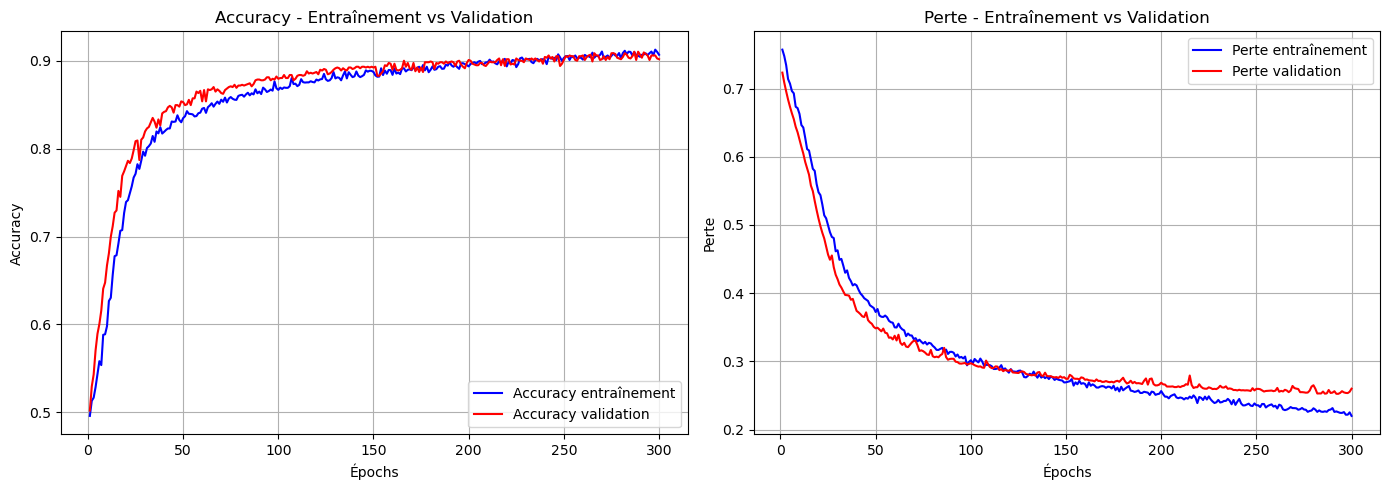

In [46]:
plot_training_history(history_transformer)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 0.9076
Precision: 0.9003
Recall: 0.9214
F1-Score: 0.9107
AUROC: 0.9622


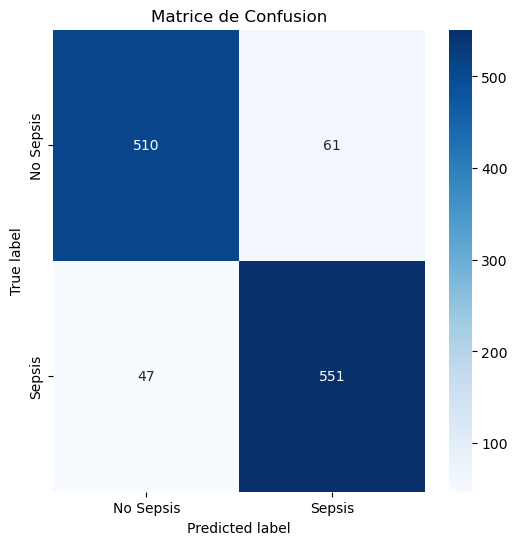

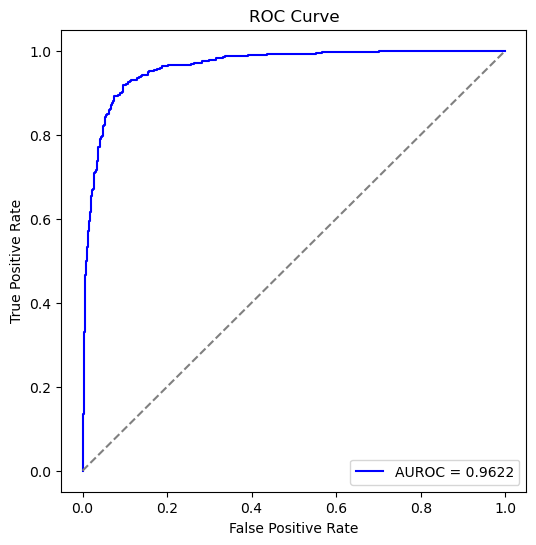

In [47]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_transformer, normalize_sequences_test, labels_test)